First step is to give in the coordinates of the location of observation together with altitude (if altitude unknown, set to 0).

In [1]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from astropy.time import Time, TimeDelta
import json

# Observer's location (latitude, longitude, altitude)
lat=47.3769*u.deg
lon=8.5417*u.deg
height=0*u.m
observer_location = EarthLocation(lat, lon, height)


Next step is to define the day on which the observation will take place.

In [2]:
from astropy.time import Time, TimeDelta
#from juliantime import GD_to_JD

cal = 'J' # either G or J, depending on if Gregorian day or Julian day is given

# Define the observation time in the local time zone
observation_time_local = Time('2024-02-27T20:00:00')

# Define the time zone offset (for Swiss winter time: UTC+01:00)
UTC_offset = 1
timezone_offset = TimeDelta(UTC_offset * u.hour)

# Convert the observation time back to UTC
observation_time_utc = observation_time_local - timezone_offset

Now to obtain the properties of a certain star, specify the right ascension (RA) and declination (Dec). Most of the properties are retrieved from the "bsc5-all.json" file apart from the distance, which is determined through the parallax. Parallax angles below 0.01 arcseconds are hard to measure which leads to a higher uncertainty on the distance.

In [3]:
from numpy import round


# Load the JSON data
with open('bsc5-all.json', 'r') as file:
    stars_data = json.load(file)

# Given RA and Dec
given_ra = "10h 08m 22s"
given_dec = "+11° 58′ 01″"

# Convert given RA and Dec to the format in the JSON data for comparison
def convert_ra_dec(ra_str, dec_str):
    ra_parts = ra_str.split(' ')
    ra_h = int(ra_parts[0][:-1])
    ra_m = int(ra_parts[1][:-1])
    ra_s = float(ra_parts[2][:-1])
    ra_decimal = ra_h + ra_m / 60 + ra_s / 3600

    dec_parts = dec_str.split(' ')
    dec_d = int(dec_parts[0][:-1])
    dec_m = int(dec_parts[1][:-1])
    dec_s = float(dec_parts[2][:-1])
    dec_decimal = dec_d + dec_m / 60 + dec_s / 3600

    return ra_decimal, dec_decimal

given_ra_decimal, given_dec_decimal = convert_ra_dec(given_ra, given_dec)

# Iterate through stars data to find a match
for star in stars_data:
    # Convert star's RA and Dec from string to decimal for comparison
    star_ra_decimal, star_dec_decimal = convert_ra_dec(star["RA"], star["Dec"])

    # Check if the given RA and Dec match the star's RA and Dec
    if abs(star_ra_decimal - given_ra_decimal) < 0.001 and abs(star_dec_decimal - given_dec_decimal) < 0.001:
        # Extract parallax and B-V magnitude if available
        BayerF = star.get("BayerF")
        common = star.get("Common")
        parallax = float(star.get("Parallax"))
        BV = float(star.get("B-V"))
        UB = float(star.get("U-B"))
        temp = float(star.get("K"))
        distance = 1/parallax
        name = star.get("Name")
        Vmag = float(star.get("Vmag"))
        
        print("Bayer Designation:", BayerF)
        print("Common Name:", common)
        print("Parallax:", parallax, "arcseconds")
        print("Surface Temperature:", temp,"K")
        print("V Magnitude:", Vmag)
        print("B-V Magnitude:", BV)
        print("U-B Magnitude:", UB)
        print("Distance:", round(distance,1),"ps / ", round(distance*3.262, 1),"ly")
        break
else:
    print("Star not found in the data.")

Bayer Designation: α Leonis
Common Name: Regulus
Parallax: 0.045 arcseconds
Surface Temperature: 16000.0 K
V Magnitude: 1.35
B-V Magnitude: -0.11
U-B Magnitude: -0.36
Distance: 22.2 ps /  72.5 ly


If one wants to print out all the properties, run this part with `print_all` set to yes:

In [4]:
print_all = "no"

if print_all == "yes":
    for star in stars_data:
        # Convert star's RA and Dec from string to decimal for comparison
        star_ra_decimal, star_dec_decimal = convert_ra_dec(star["RA"], star["Dec"])

        # Check if the given RA and Dec match the star's RA and Dec
        if abs(star_ra_decimal - given_ra_decimal) < 0.001 and abs(star_dec_decimal - given_dec_decimal) < 0.001:
            # Print all properties of the matching star
            for key, value in star.items():
                print(f"{key}: {value}")
            break

Now given the observers location and time, together with the equitorial coordinates of the object to be observed one can retrieve the horizontal coordinates:

In [5]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from astropy.time import Time
from numpy import sin, cos, arcsin, degrees

# Convert latitude to radians
lat_rad = lat.to(u.rad)

# Convert equatorial coordinates to SkyCoord object
equatorial_coords = SkyCoord(given_ra_decimal, given_dec_decimal, unit=(u.hourangle, u.deg), frame='icrs')

# Calculate horizontal coordinates
altaz_coords = equatorial_coords.transform_to(AltAz(obstime=observation_time_utc, location=EarthLocation(lat=lat, lon=lon, height=height)))

# Extract azimuth and altitude
azimuth = altaz_coords.az
altitude = altaz_coords.alt

print("Azimuth:", azimuth)
print("Altitude:", altitude)

if altitude < 0:
    print("not visible during that time")


Azimuth: 103d09m53.61279653s
Altitude: 27d41m08.77555204s


One can determine the trail it will leave across the sky, some hours before and after the set observation time.

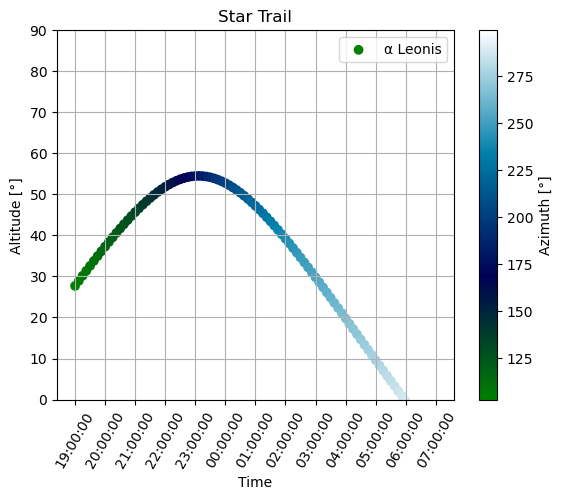

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import sigma, pi

# Define time range for trail calculation (12 hours before and after observation time)
hours_before = 0
hours_after = 12
start_time = observation_time_utc - TimeDelta(hours_before * u.hour)
end_time = observation_time_utc + TimeDelta(hours_after * u.hour)
times = start_time + (end_time - start_time) * np.linspace(0, 1, 97)[:, None]

# Calculate coordinates at each time step
altitudes = []
azimuths = []

for time in times:
    altaz_coords = equatorial_coords.transform_to(AltAz(obstime=time, location=EarthLocation(lat=lat, lon=lon, height=height)))
    altitude = altaz_coords.alt
    azimuth = altaz_coords.az
    altitudes.append(altitude)
    azimuths.append(azimuth)

# Convert lists to arrays
altitudes = np.array(altitudes)
azimuths = np.array(azimuths)
azimuths_flat = azimuths.flatten()
datetime_objects = [Time(time[0]).to_datetime() for time in times]

# Extract only the time component from datetime objects and convert to string
time_components = [dt.time().strftime('%H:%M:%S') for dt in datetime_objects]

# Plot the trail
plt.scatter(time_components, altitudes, c=azimuths_flat, cmap='ocean', label=BayerF)
plt.colorbar(label='Azimuth [°]')  # Add color bar indicating azimuth
plt.xticks(time_components[::8], rotation=60)
plt.title('Star Trail')
plt.xlabel('Time')
plt.ylabel('Altitude [°]')
plt.ylim(0,90)
plt.legend()
plt.grid(True)
plt.show()

To determine the apparent size one would first need to determine the photon flux:
$$
\begin{equation}
|S(\bold{\Omega})|^2 = \frac{\nu^2/c^2}{e^{h\nu/(kT(\bold{\Omega}))}-1}
\end{equation}
$$
where $|S(\bold{\Omega})|^2$ is the photon flux coming from direction $\bold{\Omega}$ on the sky with units of photons m$^2$ sr$^{-1}$s$^{-1}$Hz$^{-1}$, where we are assuming the photons coming from a blackbody source with temperature profile map of $T(\bold{\Omega})$. We will for now assume a homogeneous spherically shaped temperature profile with $T$ being the effective temperature.
Next we determine the spectral photon flux density, also referred to as the count degeneracy, which has the units of photons m$^{-2}$ s$^{-1}$ Hz$^{-1}$. It is found through
$$
\begin{equation}
\Phi = \frac{1}{2h\nu}\cdot 10^{-22.44-M_i/2.5} \text{ W m$^{-2}$ Hz$^{-1}$}
\end{equation}
$$
where $\nu = c/\lambda$ is the frequency or wavelength of the filter used. We have the wavelengths 364 nm for U, 442 nm for B, 540 nm for V. Finally the area in steradians can be determined through
$$
\begin{equation}
A_\text{in sr} = \frac{\Phi}{|S(\bold{\Omega})|^2}
\end{equation}
$$
and convert the area in steradians to radians

In [10]:
from scipy.constants import c, h, k, e
M_V = Vmag
M_B = Vmag+BV
M_U = M_B+UB
U_lambda = 364*10**(-9)
V_lambda = 540*10**(-9)
B_lambda = 442*10**(-9)
filters = [["U", "V", "B"], [M_U, M_V, M_B], [U_lambda, V_lambda, B_lambda]]
diameters = []
for i in range(len(filters[0])):  # Iterating over the filters
    filter_name = filters[0][i]
    magnitude = filters[1][i]
    lambda_ = filters[2][i]

    nu = c / lambda_
    Phi = 10**(-22.44 - magnitude / 2.5) / (2 * nu * h)
    S = (nu**2 / c**2) / np.exp((h * nu) / (k * temp))
    area_steradian = Phi / S

    radius_radians = np.sqrt(area_steradian / (pi))
    diameter = (6 / pi) * 60**3 * radius_radians
    diameters.append(diameter)
    print("Diameter determined through", filter_name, "filter:", np.round(diameter * 10**3, 2), "mas")


Diameter determined through U filter: 1.12 mas
Diameter determined through V filter: 1.09 mas
Diameter determined through B filter: 1.02 mas
[0.0011205348878184313, 0.0010902400498651612, 0.0010215030923568875]
